In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

### Importing The Datasets

In [ ]:
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
true = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


### Cleaning our Datasets

In [ ]:
true = true.iloc[:,:-1]
fake = fake.iloc[:,:-1]

In [ ]:
true = true.dropna()
fake = fake.dropna()

In [ ]:
true['label'] = 1
fake['label'] = 0

### Merging all the data

In [ ]:
df = pd.concat([true, fake], ignore_index=True)

In [ ]:
df.head()

,title,text,subject,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1


### Describing our Dataset

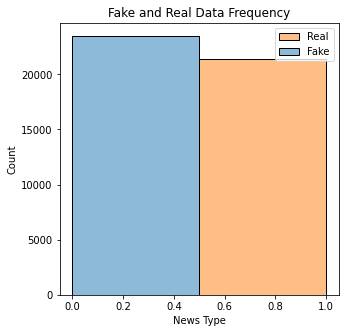

In [ ]:
plt.figure(figsize = (5,5))
sns.histplot(data = df, x = 'label', hue='label', bins = 2)
plt.xlabel("News Type")
plt.title("Fake and Real Data Frequency")
plt.legend(["Real","Fake"])
plt.show()

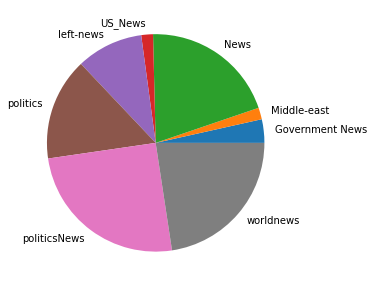

In [ ]:
plt.figure(figsize = (5,5))
plt.pie(df.groupby(['subject']).subject.count(), labels=df.groupby(['subject']).subject.count().index)
plt.show()

### Tokenization, Normalization & Substitution

In [ ]:
df.text = df.title + " " + df.text
df = df.loc[:, ['text','label']]

In [ ]:
#lowercase, punctuation and removing numbers
df.text = df.text.map(lambda x:x.lower())
df.text = df.text.map(lambda x:x.translate(str.maketrans('', '', string.punctuation)))
df.text = df.text.str.replace('\d', '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [ ]:
#removing stopwords such as prepositions
stopwords = stopwords.words('english')
df.text = df.text.map(lambda x: " ".join(_ for _ in x.split() if _ not in stopwords))

In [ ]:
#lemmatizing the words, i.e. grouping similar words together
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
df.text = df.text.map(lambda x: " ".join(lemmatizer.lemmatize(_) for _ in x.split()))

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [ ]:
X, y = df.text, df.label
train_X, test_X, train_y, test_y = train_test_split(X, y, shuffle=True)

In [ ]:
tokenizer_m = Tokenizer(num_words=10000)
tokenizer_m.fit_on_texts(train_X)              #updating internal vocabulary based on the texts in training data
tokenized_train_X, tokenized_test_X = tokenizer_m.texts_to_sequences(train_X), tokenizer_m.texts_to_sequences(test_X)       #creating integer sequences corresponding to the words
train_X = pad_sequences(tokenized_train_X, padding='post', maxlen=500)              #padding to have equal length for each sequences
test_X = pad_sequences(tokenized_test_X, padding='post', maxlen=500)

### Training a LSTM model

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(10000, 200))             #converting the integer sequences to dense vectors
model.add(keras.layers.LSTM(100, return_sequences = True))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.LSTM(50))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(20, 'relu'))
model.add(keras.layers.Dense(1, 'sigmoid'))

2023-01-02 14:10:46.226718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 14:10:46.318213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 14:10:46.319086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 14:10:46.320895: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         120400    
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
fitted_model = model.fit(train_X, train_y, epochs= 6, validation_split=0.25, batch_size=15, shuffle=True)

Epoch 1/6


2023-01-02 14:10:49.576073: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-02 14:10:52.904653: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1684/1684 [==============================] - 83s 47ms/step - loss: 0.6920 - accuracy: 0.5179 - val_loss: 0.6871 - val_accuracy: 0.5213
Epoch 2/6
1684/1684 [==============================] - 78s 46ms/step - loss: 0.3081 - accuracy: 0.8347 - val_loss: 0.0399 - val_accuracy: 0.9901
Epoch 3/6
1684/1684 [==============================] - 77s 46ms/step - loss: 0.0421 - accuracy: 0.9895 - val_loss: 0.0329 - val_accuracy: 0.9912
Epoch 4/6
1684/1684 [==============================] - 77s 46ms/step - loss: 0.0403 - accuracy: 0.9898 - val_loss: 0.0281 - val_accuracy: 0.9924
Epoch 5/6
1684/1684 [==============================] - 78s 46ms/step - loss: 0.0326 - accuracy: 0.9923 - val_loss: 0.0267 - val_accuracy: 0.9931
Epoch 6/6
1684/1684 [==============================] - 77s 46ms/step - loss: 0.0291 - accuracy: 0.9935 - val_loss: 0.0254 - val_accuracy: 0.9928


#### 99.28% Accuracy on the validation data

<AxesSubplot:>

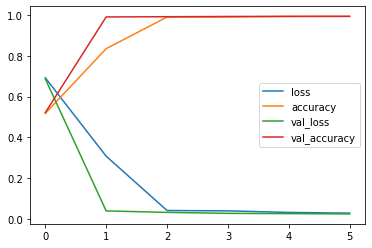

In [ ]:
pd.DataFrame(fitted_model.history).plot()

In [ ]:
pred_test_y = np.argmax(model.predict(test_X), axis = 1)
print(classification_report(pred_test_y, test_y))

              precision    recall  f1-score   support

           0       1.00      0.53      0.69     11225
           1       0.00      0.00      0.00         0

    accuracy                           0.53     11225
   macro avg       0.50      0.26      0.35     11225
weighted avg       1.00      0.53      0.69     11225



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.evaluate(test_X, test_y)

351/351 [==============================] - 6s 18ms/step - loss: 0.0340 - accuracy: 0.9909


[0.034012194722890854, 0.9909131526947021]

### Great! 99.09% Accuracy on the Test Data!